# US Census Dataset
#### Author: Peter Martigny
#### Date: January 2017

## The goal of this project is to predict whether an American inhabitant earns more or less than $50 000 a year, based on her/his personal characteristics.
We use tha dataset "US Census", which is a survey over 300 000 Americans.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', False) # set options to see all columns
import numpy as np

#### Import statements

In [2]:
data = pd.read_csv('census_income_learn.csv', header=None)
data_test = pd.read_csv('census_income_test.csv', header=None)

In [3]:
print("Both datasets contain {} columns. The train set has {} rows, and the test set has {} rows".format(data.shape[1], len(data), len(data_test)))
print('Hence, {} percent of the whole dataset is kept for the training part, the rest for the test part.'.format(100*(len(data) / (len(data) + len(data_test)))))

Both datasets contain 42 columns. The train set has 199523 rows, and the test set has 99762 rows
Hence, 66.66655529010809 percent of the whole dataset is kept for the training part, the rest for the test part.


#### Statistics for train set

In [4]:
# Number of rows
print('Number of instances data =', len(data))
# Number of duplicates (this is not necessarily a bad things, since it is possible that 
# 2 persons share the same characteristics)
print('Number of rows with same characteristics =', len(data) - len(data.drop_duplicates()) )

target = data[41].value_counts()
print(target)
print('Probability for the label 50000+ =', target[1] / (target[0] + target[1]))
print('Probability for the label -50000 =', target[0] / (target[0] + target[1]))

Number of instances data = 199523
Number of rows with same characteristics = 3229
 - 50000.    187141
 50000+.      12382
Name: 41, dtype: int64
Probability for the label 50000+ = 0.0620580083499
Probability for the label -50000 = 0.93794199165


In [5]:
# As explained in the metadata, we do not use the instance weights variable, which is the column 
# 24. We remove the column and reset the columns index
del data[24]
data.columns = np.arange(0, 41)

del data_test[24]
data_test.columns = np.arange(0, 41)

In [6]:
# Are there any missing data?
data.isnull().sum().sum()

0

The dataset has no apparent missing value. In facts, there are missing values, but they are considered as categories within categorical variables. Hence, we will use them as such, not deleting them.

In [7]:
# Let's separate continuous and categorical variables
continuous = [0, 5, 16, 17, 18, 29, 38]
categorical = [x for i, x in enumerate(list(data.columns)) if x not in continuous]
#  Some variables are considered as continuous whereas they are prsented as categorical 
# in the metadata file. Thus, we force them to be continuous.
for i in [2, 3, 35, 37, 39]:
    data[i] = data[i].apply(str)

In [8]:
# Descriptive statistics for continuous variables
data.describe().T

,count,mean,std,min,25%,50%,75%,max
0,199523.0,34.494199,22.310895,0.0,15.0,33.0,50.0,90.0
5,199523.0,55.426908,274.896454,0.0,0.0,0.0,0.0,9999.0
16,199523.0,434.718990,4697.531280,0.0,0.0,0.0,0.0,99999.0
17,199523.0,37.313788,271.896428,0.0,0.0,0.0,0.0,4608.0
18,199523.0,197.529533,1984.163658,0.0,0.0,0.0,0.0,99999.0
29,199523.0,1.956180,2.365126,0.0,0.0,1.0,4.0,6.0
38,199523.0,23.174897,24.411488,0.0,0.0,8.0,52.0,52.0


In [9]:
# Descriptive statistics for continuous variables
data.corr()

,0,5,16,17,18,29,38
0,1.000000,0.036938,0.053590,0.063351,0.104976,0.140887,0.206181
5,0.036938,1.000000,-0.001082,0.010993,-0.005731,0.191543,0.195687
16,0.053590,-0.001082,1.000000,-0.012700,0.131476,0.058015,0.083549
17,0.063351,0.010993,-0.012700,1.000000,0.042427,0.084255,0.100762
18,0.104976,-0.005731,0.131476,0.042427,1.000000,0.007206,0.013823
29,0.140887,0.191543,0.058015,0.084255,0.007206,1.000000,0.747302
38,0.206181,0.195687,0.083549,0.100762,0.013823,0.747302,1.000000


In [10]:
# Descriptive statistics for categorical variables
data[categorical].describe().T

,count,unique,top,freq
1,199523,9,Not in universe,100245
2,199523,52,0,100684
3,199523,47,0,100684
4,199523,17,High school graduate,48407
6,199523,3,Not in universe,186943
7,199523,7,Never married,86485
8,199523,24,Not in universe or children,100684
9,199523,15,Not in universe,100684
10,199523,5,White,167365
11,199523,10,All other,171907


In [11]:
# Now, let's scale the continuous data
data_continuous = data[continuous]
for variable in continuous:
    mean = data[variable].mean()
    std = data[variable].std()
    data[variable] = (data[variable] - mean) / std
    data_continuous[variable] = (data_continuous[variable] - mean) / std

C:\Users\Peter martigny\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
data_continuous.describe().T

,count,mean,std,min,25%,50%,75%,max
0,199523.0,-3.435163e-16,1.0,-1.546070,-0.873752,-0.066972,0.694988,2.487834
5,199523.0,-1.810052e-15,1.0,-0.201628,-0.201628,-0.201628,-0.201628,36.172068
16,199523.0,-5.824909e-15,1.0,-0.092542,-0.092542,-0.092542,-0.092542,21.195022
17,199523.0,-2.138945e-15,1.0,-0.137235,-0.137235,-0.137235,-0.137235,16.810394
18,199523.0,3.099611e-15,1.0,-0.099553,-0.099553,-0.099553,-0.099553,50.299011
29,199523.0,9.308582e-15,1.0,-0.827094,-0.827094,-0.404283,0.864148,1.709770
38,199523.0,5.221289e-15,1.0,-0.949344,-0.949344,-0.621629,1.180801,1.180801


In [13]:
data.corr()

,0,5,16,17,18,29,38
0,1.000000,0.036938,0.053590,0.063351,0.104976,0.140887,0.206181
5,0.036938,1.000000,-0.001082,0.010993,-0.005731,0.191543,0.195687
16,0.053590,-0.001082,1.000000,-0.012700,0.131476,0.058015,0.083549
17,0.063351,0.010993,-0.012700,1.000000,0.042427,0.084255,0.100762
18,0.104976,-0.005731,0.131476,0.042427,1.000000,0.007206,0.013823
29,0.140887,0.191543,0.058015,0.084255,0.007206,1.000000,0.747302
38,0.206181,0.195687,0.083549,0.100762,0.013823,0.747302,1.000000


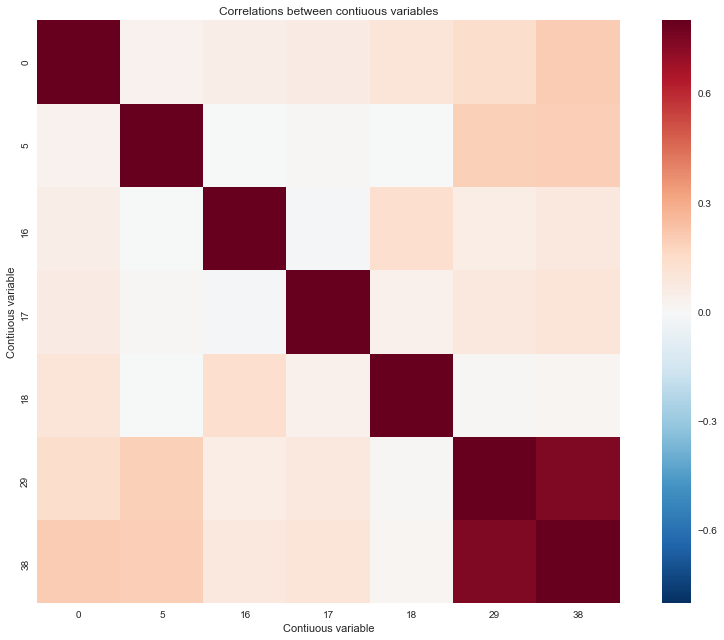

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.xlabel('Contiuous variable')
plt.ylabel('Contiuous variable')
plt.title('Correlations between contiuous variables')
f.tight_layout()

We observe that the variables 29 and 38 are highly correlated. We decide to remove the variable 29 (we want to keep the number of weeks worked in years!)

In [15]:
del data[29]

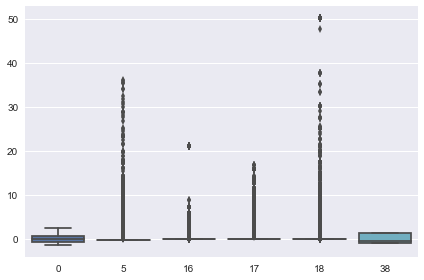

In [16]:
continuous = [0, 5, 16, 17, 18, 38]
categorical = [x for i, x in enumerate(list(data.columns)) if x not in continuous]

ax = sns.boxplot(data=data[continuous],orient='v')
plt.tight_layout()
plt.show()

We see that variable 5, 16, 17 and 18 are really concentrated, but with some outliers. Variables 0 and 38 have less outlisers but have a larger spread.

Let's plot the boxplots without outliers:

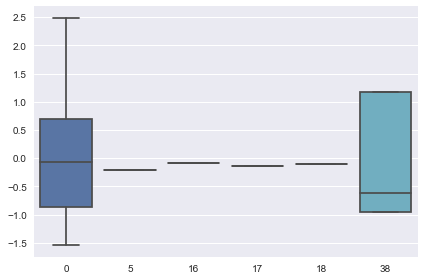

In [17]:
ax = sns.boxplot(data=data[continuous],orient='v', showfliers=False)
plt.tight_layout()
plt.show()

## Features engineering

In [18]:
X = data.ix[:, :39]
y = data[40]

In [19]:
categorical.remove(40)

In [20]:
# Now, we want to dummify the categorical variables. Let's have a look:
pd.get_dummies(X[categorical]).head()

,1_ Federal government,1_ Local government,1_ Never worked,1_ Not in universe,1_ Private,1_ Self-employed-incorporated,1_ Self-employed-not incorporated,1_ State government,1_ Without pay,2_0,2_1,2_10,2_11,2_12,2_13,2_14,2_15,2_16,2_17,2_18,2_19,2_2,2_20,2_21,2_22,2_23,2_24,2_25,2_26,2_27,2_28,2_29,2_3,2_30,2_31,2_32,2_33,2_34,2_35,2_36,...,33_ India,33_ Iran,33_ Ireland,33_ Italy,33_ Jamaica,33_ Japan,33_ Laos,33_ Mexico,33_ Nicaragua,33_ Outlying-U S (Guam USVI etc),33_ Panama,33_ Peru,33_ Philippines,33_ Poland,33_ Portugal,33_ Puerto-Rico,33_ Scotland,33_ South Korea,33_ Taiwan,33_ Thailand,33_ Trinadad&Tobago,33_ United-States,33_ Vietnam,33_ Yugoslavia,34_ Foreign born- Not a citizen of U S,34_ Foreign born- U S citizen by naturalization,34_ Native- Born abroad of American Parent(s),34_ Native- Born in Puerto Rico or U S Outlying,34_ Native- Born in the United States,35_0,35_1,35_2,36_ No,36_ Not in universe,36_ Yes,37_0,37_1,37_2,39_94,39_95
0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,1
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,1,0
2,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1
3,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,1,0
4,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,1,0


#### Warning: the following cell can take a few minutes

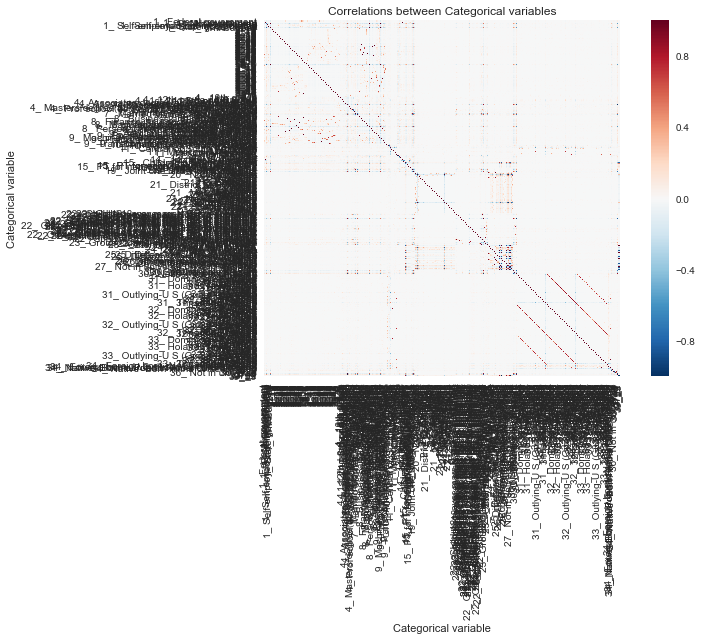

In [21]:
# Let's have a look at the correlations between categorical variables
corrmat = pd.get_dummies(X[categorical]).corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.xlabel('Categorical variable')
plt.ylabel('Categorical variable')
plt.title('Correlations between Categorical variables')
f.tight_layout()

Some features are highly correlated. However, it seems not straightforward to asses which variables to remove. I choose not to remove variables.

In [22]:
# Here, we transform the target variable into a 0/1 binary variable
def binarize(x):
    if x == ' - 50000.':
        return 0
    else:
        return 1
y = y.apply(binarize)

In [23]:
y.value_counts()

0    187141
1     12382
Name: 40, dtype: int64

#### Who earns more than 50 000 a year?

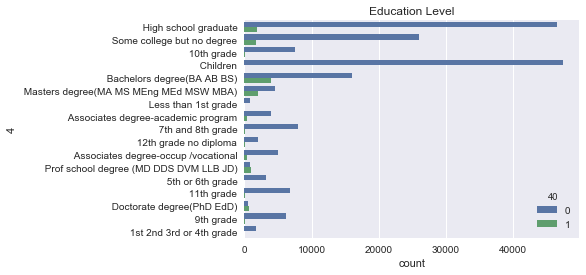

In [24]:
sns.countplot(y=X[4], hue=y)
plt.title('Education Level')
plt.show()

We see that whealthy people are amongst thos who have at least a high school degree.

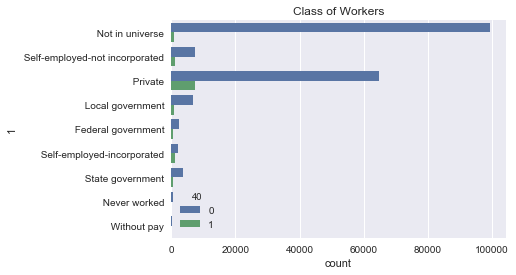

In [25]:
sns.countplot(y=X[1], hue=y)
plt.title('Class of Workers')
plt.show()

There are more wealthy people in the private sector.

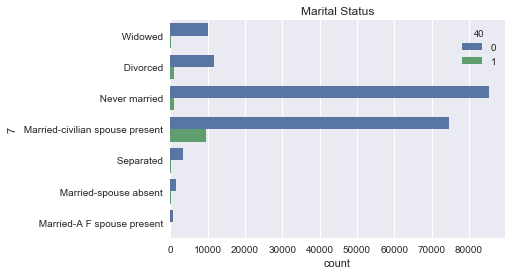

In [26]:
sns.countplot(y=X[7], hue=y)
plt.title('Marital Status')
plt.show()

Wealthy people are generally married.

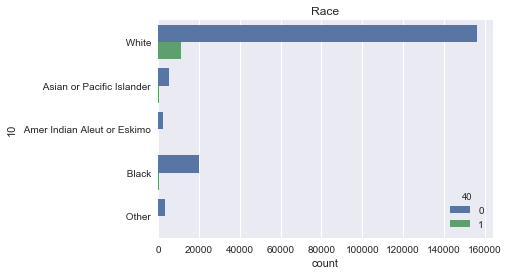

In [27]:
sns.countplot(y=X[10], hue=y)
plt.title('Race')
plt.show()

Welathy people are generally white.

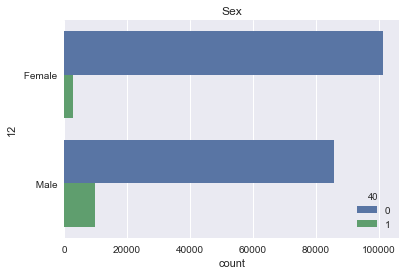

In [28]:
sns.countplot(y=X[12], hue=y)
plt.title('Sex')
plt.show()

Men are more likely to be welathy than women.

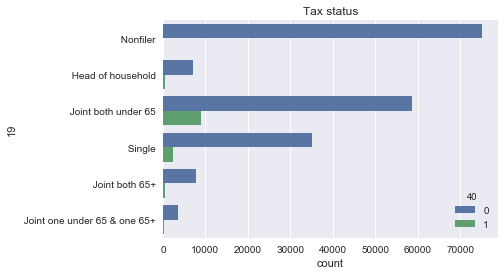

In [29]:
sns.countplot(y=X[19], hue=y)
plt.title('Tax status')
plt.show()

Joint both under 65 and singles are most likely wealthy.

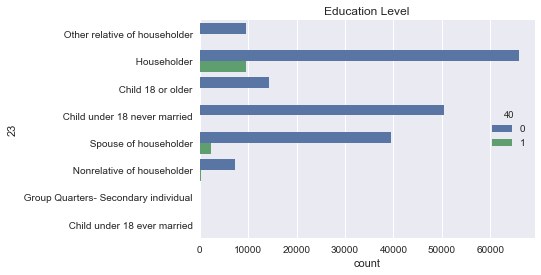

In [30]:
sns.countplot(y=X[23], hue=y)
plt.title('Education Level')
plt.show()

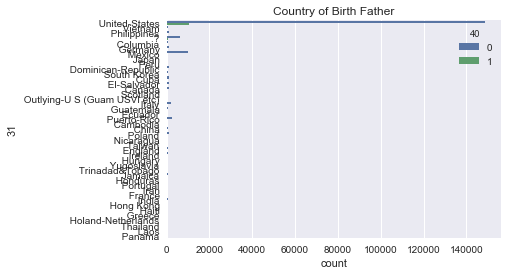

In [31]:
sns.countplot(y=X[31], hue=y)
plt.title('Country of Birth Father')
plt.show()

Wealthy people have their father born in the USA.

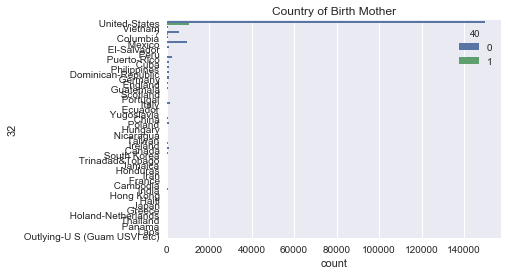

In [32]:
sns.countplot(y=X[32], hue=y)
plt.title('Country of Birth Mother')
plt.show()

Wealthy people have their mother born in the USA.

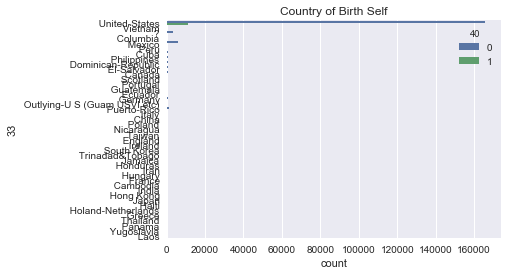

In [33]:
sns.countplot(y=X[33], hue=y)
plt.title('Country of Birth Self')
plt.show()

Wealthy people were themselves born in the USA.

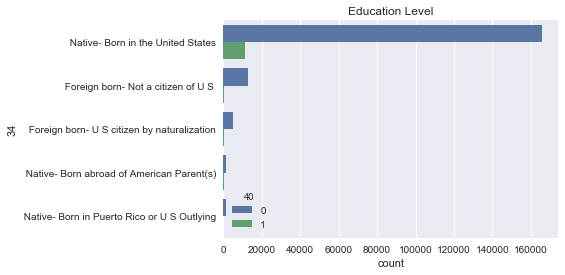

In [34]:
sns.countplot(y=X[34], hue=y)
plt.title('Education Level')
plt.show()

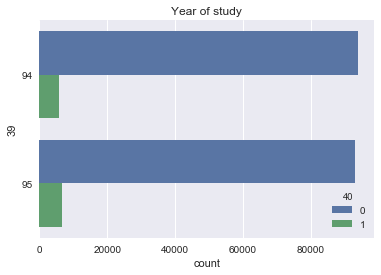

In [35]:
sns.countplot(y=X[39], hue=y)
plt.title('Year of study')
plt.show()

Year of study does not affect wealth.

From what we just saw, several things can be done to continue our study:

- The year of study is not discriminant, we remove it.
- Countries of birth for parents and themselves are highly interdependant, we choos to keep only one variable, the variable 34 with only 5 categories

In [36]:
categorical.remove(31)
categorical.remove(32)
categorical.remove(33)
categorical.remove(39)

In [37]:
# We concatenate the continuous variables with the dummified categorical variables
X = pd.concat((X[continuous], pd.get_dummies(X[categorical])), axis=1)

In [38]:
print('There are now {} variables in our dataset'.format(X.shape[1]))

There are now 378 variables in our dataset


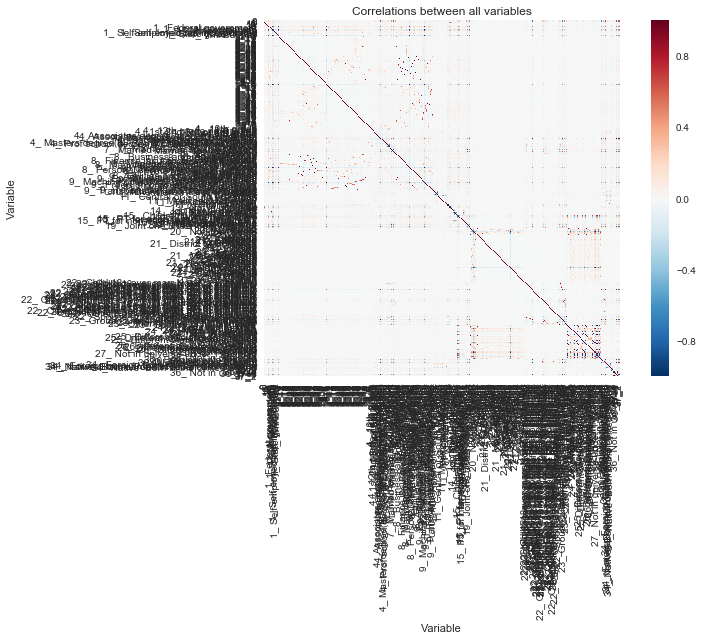

In [39]:
corrmat = X.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.xlabel('Variable')
plt.ylabel('Variable')
plt.title('Correlations between all variables')
f.tight_layout()

# Machine Learning

Now that we have prepared the features for our dataset, we use machine learning algorithms to carry out the binary classification task.

Before doing anything, we observe that the target variable is clearly imbalanced.

In [40]:
y.value_counts()

0    187141
1     12382
Name: 40, dtype: int64

One solution to imbalanced data, when we want to separare the data into train and test sets, is that we want to keep the same distribution of the data in both sets. This is feasable with stratified sampling using sklearn.

However, here, since the target variable is too much imbalanced, there's a high risk that any predictor will always predict the dominant class! Indeed, whatever happens, this will produce a very good accuracy! 

In [41]:
print("Always predicting the dominant class would produce an accuracy of", len(y[y == 0]) / len(y))

Always predicting the dominant class would produce an accuracy of 0.9379419916500854


One solution is to keep all instances of non dominant class, and sampling over the dominant class siuch that boith classes are equivalantly represented. We will then have more confidance in our classification algorithm. The downside is that we loose some data...

In [42]:
# Index of positive and negative data
index_positive = list(y[y == 1].index)
index_negative = list(y[y == 0].index)
# Sample over the negative data
index_negative_sample = list(y[index_negative].sample(12382).index)
index_final = index_negative_sample + index_positive
# Produce the final features and target variable to use for the learning part.
y = y[index_final]
X = X.ix[index_final]

In [43]:
y.value_counts()

1    12382
0    12382
Name: 40, dtype: int64

Now, we separate the dataset into rtain and test sets.

In [44]:
from sklearn.model_selection import train_test_split
# We split the data into train and test data. Here we keep 30% of the data for testing
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                                    y, test_size=0.3, 
                                                                    random_state=42)

In [45]:
# We define here the metrics that we will use

def accuracy(predicted, true):
    return (predicted == true).sum() / len(true)
def precision(predicted, true):
    numerator = ((predicted == true) & (true == 1)).sum()
    denominator = ((predicted == true) & (true == 1)).sum() + ((predicted != true) & (true == 0)).sum()
    return numerator / denominator
def recall(predicted, true):
    numerator = ((predicted == true) & (true == 1)).sum()
    denominator = ((predicted == true) & (true == 1)).sum() + ((predicted != true) & (true == 1)).sum()
    return numerator / denominator    
def f1_score(predicted, true):
    a = precision(predicted, true)
    b = recall(predicted, true)
    return 2 * (a*b)/(a+b)

Let's compute these metrics in the case where we predict randomly $0$ or $1$.
This will give us metrics to be outperformed by our strategies.

In [46]:
from random import randint
pred = [randint(0, 1) for i in range(len(y_test))]

print("Accuracy =", accuracy(pred, y_test))
print("Precision =", precision(pred, y_test))
print("Recall =", recall(pred, y_test))
print("F1_score =", f1_score(pred, y_test))

Accuracy = 0.494751009421
Precision = 0.4943273906
Recall = 0.492995689655
F1_score = 0.493660642029


From now, the goal is to do better than that!

#### Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression
import time

model_log = LogisticRegression()

start = time.clock()
print('Start training')
model_log.fit(X_train, y_train)
print('Training done!')
print('The algorithms ran for {} seconds'.format(time.clock() - start))
pred = model_log.predict(X_test)

Start training
Training done!
The algorithms ran for 0.7844491000292741 seconds


In [48]:
print("Accuracy =", accuracy(pred, y_test))
print("Precision =", precision(pred, y_test))
print("Recall =", recall(pred, y_test))
print("F1_score =", f1_score(pred, y_test))

Accuracy = 0.870390309556
Precision = 0.853251092264
Recall = 0.894396551724
F1_score = 0.873339471261


We see that a siple logistic regression outperforms the random classifier for all metrics.

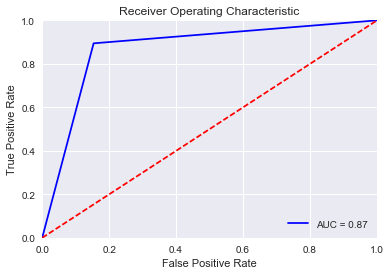

In [49]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [50]:
# Implement a 5-Fold Cross Validation
from sklearn.model_selection import cross_val_score
score_logistic = cross_val_score(model_log, X, y, cv=5)
print('The results of the 5-Fold cross validation is', score_logistic)
print("The mean score for 5-Fold cross validation is", score_logistic.mean())

The results of the 5-Fold cross validation is [ 0.88574889  0.87242632  0.87075929  0.86591276  0.8598546 ]
The mean score for 5-Fold cross validation is 0.870940373569


#### Decision tree classifier

In [51]:
# With trees, we can have access to each variable's importance
def plot_features(model_features, initial_data, n):

    a = pd.DataFrame(model_features).sort_values(by=0, ascending = False)
    a.index = initial_data.columns
    a = a[:n]

    xs = np.arange(len(a))
    plt.barh(xs, a[0], align='center', alpha=1)
    plt.yticks(xs, a.index)
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Which features contribute most to the predictions?')
    plt.gca().invert_yaxis()
    plt.show()

Start training
Training done!
The algorithms ran for 0.8669249844641911 seconds


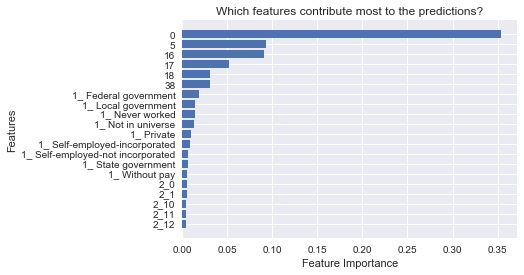

Accuracy = 0.822476446837
Precision = 0.829705152935
Recall = 0.811153017241
F1_score = 0.820324206511


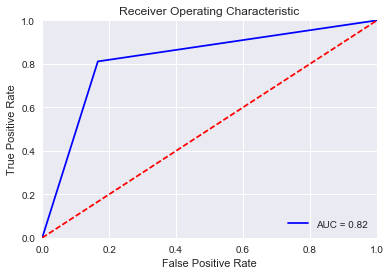

In [52]:
from sklearn.tree import DecisionTreeClassifier
model_tree = DecisionTreeClassifier(min_samples_split=5)

start = time.clock()
print('Start training')
model_tree.fit(X_train, y_train)
print('Training done!')
print('The algorithms ran for {} seconds'.format(time.clock() - start))
pred = model_tree.predict(X_test)

plot_features(model_tree.feature_importances_, X, 20)
print("Accuracy =", accuracy(pred, y_test))
print("Precision =", precision(pred, y_test))
print("Recall =", recall(pred, y_test))
print("F1_score =", f1_score(pred, y_test))

fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [53]:
# Implement a 5-Fold Cross Validation
score_tree = cross_val_score(model_tree, X, y, cv=5)
print('The results of the 5-Fold cross validation is', score_tree)
print("The mean score for 5-Fold cross validation is", score_tree.mean())

The results of the 5-Fold cross validation is [ 0.83185305  0.82539362  0.82108239  0.82148627  0.81522617]
The mean score for 5-Fold cross validation is 0.823008299946


#### Random Forest Classifier

Start training
Training done!
The algorithms ran for 0.6139289338978529 seconds
Accuracy = 0.860565275908
Precision = 0.846991701245
Recall = 0.879849137931
F1_score = 0.86310782241


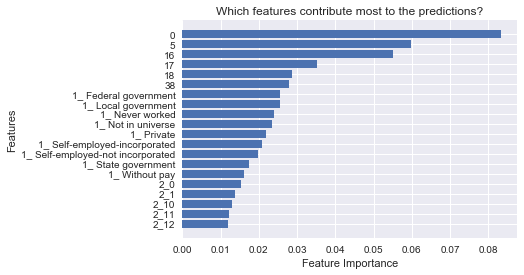

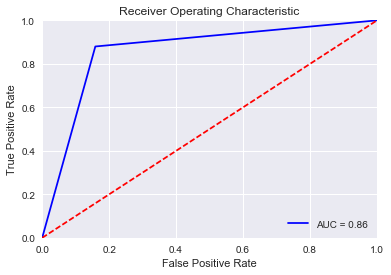

In [54]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=40, n_jobs=-1)

start = time.clock()
print('Start training')
model_rf.fit(X_train, y_train)
print('Training done!')
print('The algorithms ran for {} seconds'.format(time.clock() - start))
pred = model_rf.predict(X_test)

print("Accuracy =", accuracy(pred, y_test))
print("Precision =", precision(pred, y_test))
print("Recall =", recall(pred, y_test))
print("F1_score =", f1_score(pred, y_test))

plot_features(model_rf.feature_importances_, X, 20)

fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [55]:
# Implement a 5-Fold Cross Validation
score_rf = cross_val_score(model_rf, X, y, cv=5)
print('The results of the 5-Fold cross validation is', score_rf)
print("The mean score for 5-Fold cross validation is", score_rf.mean())

The results of the 5-Fold cross validation is [ 0.87949132  0.8645539   0.85743134  0.85561389  0.85238288]
The mean score for 5-Fold cross validation is 0.861894665168


#### Gradient Boosting Classifier

Start training
Training done!
The algorithms ran for 16.412825842104034 seconds
Accuracy = 0.868775235532
Precision = 0.849731663685
Recall = 0.895743534483
F1_score = 0.872131147541


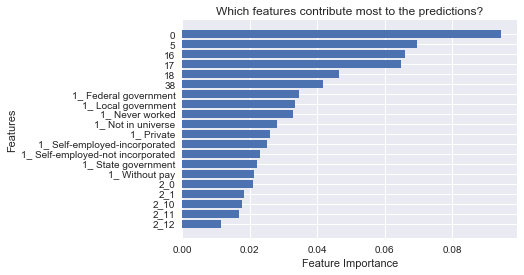

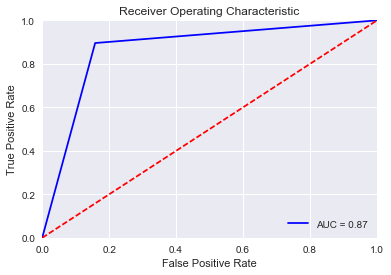

In [56]:
from sklearn.ensemble import GradientBoostingClassifier

model_gb = GradientBoostingClassifier()

start = time.clock()
print('Start training')
model_gb.fit(X_train, y_train)
print('Training done!')
print('The algorithms ran for {} seconds'.format(time.clock() - start))
pred = model_gb.predict(X_test)

print("Accuracy =", accuracy(pred, y_test))
print("Precision =", precision(pred, y_test))
print("Recall =", recall(pred, y_test))
print("F1_score =", f1_score(pred, y_test))

plot_features(model_gb.feature_importances_, X, 20)

fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [57]:
# Implement a 5-Fold Cross Validation
score_gb = cross_val_score(model_gb, X, y, cv=5)
print('The results of the 5-Fold cross validation is', score_gb)
print("The mean score for 5-Fold cross validation is", score_gb.mean())

The results of the 5-Fold cross validation is [ 0.8847396   0.86879289  0.86631664  0.86571082  0.86126817]
The mean score for 5-Fold cross validation is 0.869365627423


#### Support Vector Machine (Classifier)

Start training
Training done!
The algorithms ran for 88.31786284162482 seconds
Accuracy = 0.865679676985
Precision = 0.832435080843
Recall = 0.915409482759
F1_score = 0.871952784193


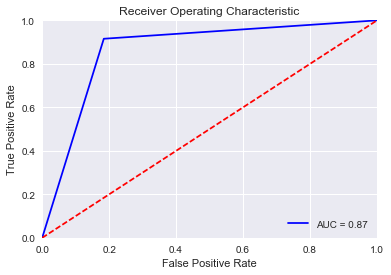

In [58]:
from sklearn.svm import SVC

model_svc = SVC()

start = time.clock()
print('Start training')
model_svc.fit(X_train, y_train)
print('Training done!')
print('The algorithms ran for {} seconds'.format(time.clock() - start))
pred = model_svc.predict(X_test)

print("Accuracy =", accuracy(pred, y_test))
print("Precision =", precision(pred, y_test))
print("Recall =", recall(pred, y_test))
print("F1_score =", f1_score(pred, y_test))

fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The SVM is very slow, and its score seems to be lower than other algorithms seen before, so we decide to not use cross validation with this algorithm.

#### Neural Network

To finish with, we try a simple neural network with one hidden layer to carry out the binary classification (We do not expect great results though, because of the nature of the data, and its amount).

In [59]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import preprocessing
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras import optimizers
from keras.utils.np_utils import to_categorical
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [60]:
# We transform the target variable
Y_train = to_categorical(y_train)
Y_train[:3]

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.]])

In [61]:
N = np.array(X_train).shape[1]
H = 100
K = 2

# Build the neural network
model = Sequential()
model.add(Dense(H, input_dim=N))
keras.layers.core.Dropout(0.8)
model.add(Activation("relu"))
model.add(Dense(K))
model.add(Activation("softmax"))

# Compile it with a good optimizer
model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy', metrics=['accuracy'])
# Fit the model
history = model.fit(np.array(X_train), np.array(Y_train), nb_epoch=15, batch_size=32)

Epoch 1/15
17334/17334 [==============================] - 3s - loss: 0.3293 - acc: 0.8543     
Epoch 2/15
17334/17334 [==============================] - 2s - loss: 0.2983 - acc: 0.8710     
Epoch 3/15
17334/17334 [==============================] - 2s - loss: 0.2895 - acc: 0.8749     
Epoch 4/15
17334/17334 [==============================] - 2s - loss: 0.2815 - acc: 0.8779     
Epoch 5/15
17334/17334 [==============================] - 2s - loss: 0.2745 - acc: 0.8826     
Epoch 6/15
17334/17334 [==============================] - 2s - loss: 0.2667 - acc: 0.8863     
Epoch 7/15
17334/17334 [==============================] - 2s - loss: 0.2568 - acc: 0.8914     
Epoch 8/15
17334/17334 [==============================] - 2s - loss: 0.2462 - acc: 0.8960     
Epoch 9/15
17334/17334 [==============================] - 2s - loss: 0.2366 - acc: 0.9016     
Epoch 10/15
17334/17334 [==============================] - 2s - loss: 0.2273 - acc: 0.9060     
Epoch 11/15
17334/17334 [========================

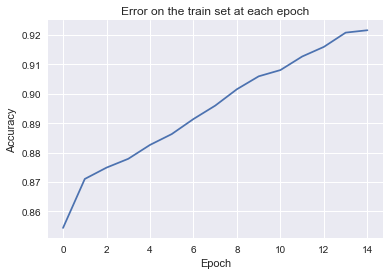

In [62]:
plt.plot(history.history['acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Error on the train set at each epoch')
plt.show()

In [63]:
# And now test on the test set
predicted = model.predict_classes(np.array(X_test))
result = sum(predicted == y_test)/len(y_test)
print("\nAccuracy =", accuracy(predicted, y_test))
print("Precision =", precision(predicted, y_test))
print("Recall =", recall(predicted, y_test))
print("F1_score =", f1_score(predicted, y_test))

7392/7430 [============================>.] - ETA: 0s
Accuracy = 0.853566621803
Precision = 0.866071428571
Recall = 0.836206896552
F1_score = 0.850877192982


We realize that the neural network overfits, even with the dropout regularizer.

# Conclusions and perspectives

The prject has consisted of several parts:

- A data analysis part, in order to understand the data
- A data cleaning part, where we had to know which variables were considered as redundant and thus remove
- A features engineering part, where we had to normalize the continuous data, and to dummify the categorical variables
- A benchmark of several classification algorithms

In the end, we realize that the first lgorithm that we tried, the logistic regression, obtains the best results.

However, here are the things that we could have done to go further:

- Carry parameter optimization using grid-search to determine the rigt parameters for each algorithm. Instead, I did it manually.
- If we wanted to be in a "Kaggle-style" spirit, we would have tried xgboost, and then we would have tried to stack several classifiers in order to make them vote and then, hopefully, increase the accuracy.
- For neural networks, we could be more cautious with regularization methods.
- In general, we could have tried a dimension reduction technique, to reduce the number of variables, and then be able to try further some much computationnally inefficient algorithms like SVMs.
- Finally, our models should be plugged into classes with a specific pipeline, so that they can be used in a more compact way.